In [1]:
## Import libraries ##
import numpy as np
import math
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd

In [2]:
## Define Basic functions ##

#generate points that aren't too close to each other
def generate_points(minX, maxX, N, dim = 1):
    min_distance = np.abs(maxX-minX)/(2*N)
    print(min_distance)
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(minX, maxX, size=(1,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.abs(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    return np.concatenate(points)


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()


#squared expo kernel
def kernel(a, b, kernelParameter_l, kernelParameter_sigma):
    #Hyperparameters:
    #kernelParameter_l = 1.94 #0.3 #1.94
    #kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo


# Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
def posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
    '''
    
    N = len(X)
    n = 200 # number of test points X*
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))

    ## 3) Predictive mean at test points
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))
    
    return Xtest, mu, std


#Given test point x (Xtest_val), what is y?
def conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Given test point x (Xtest_val), what is y?
    '''
    N = len(X)
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + sigma_n**2*np.eye(N)) 

    ## 3) Predictive mean at test points
    Xtest = np.asarray([Xtest_val]).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))

    return Xtest_val, mu, std


#plot the posterior distribution of GPR
def plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Plot the posterior distribution of GPR
    '''
    #Return mu and std:
    Xtest, mu, std = posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    print("Mean predictive std: ", np.mean(std))
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    #plt.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest.flat, mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()

## Given

Plot of dataset and the function we'd like to estimate (our goal):

1.25


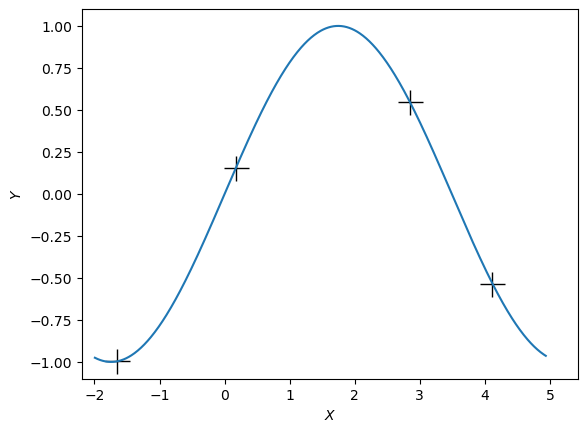

In [3]:
#This is our dataset:
N = 4 
X = generate_points(-5, 5, N, dim = 1)
y = (f(X) + np.random.normal(0,0,N)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Plot of data:
plt.plot(X, y, 'k+', ms=18)

#Function we'd like to estimate --> our goal
x = np.arange(min(X)-abs(min(X))*0.2, max(X)+abs(max(X))*0.2, 0.01).reshape(-1,1)
f_x = f(x)

#Render plots
plt.plot(x, f_x)
plt.axis([min(x)-abs(min(x))*0.1, max(x)+abs(max(x))*0.1, min(f(x))-abs(min(f(x)))*0.1,  max(f(x))+abs(max(f(x)))*0.1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

and we'll use this kernel in our GP:

We use the _Squared Exponential Kernel_, also called Radial Basis Function Kernel or Gaussian Kernel, as our covariance function:
\begin{equation}\label{eq:1}
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
\end{equation}
where the signal variance $\sigma_f^2$ (signal standard deviation $\sigma_f$) and the length scale $l$ are _hyperparameters_ which we'll want to optimize. In this example, this would result in a $n$x$n$ positive-definite covariance matrix $K$ where each element is $\kappa(x_i,x_j)$ with $x_i,x_j$ taken from the $n$ evenly spaced $x$ values for all $i,j\in \{1\ldots,n\}$.

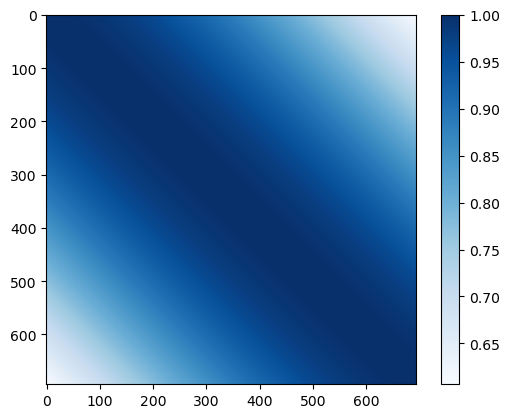

In [5]:
#Plot of kernel
x = x.reshape(-1,1)
x = (x - np.min(x))/(np.max(x) - np.min(x)) #X in [0,1]
K = kernel(x, x, 1, 1)

plt.imshow(K, cmap = 'Blues', interpolation = 'nearest')
plt.colorbar()
plt.show()

In [6]:
#Normalize feature:
X = (X - np.min(X))/(np.max(X) - np.min(X)) #X in [0,1]

#Normalize target:
#y = (y - min(y))/(max(y)-min(y))

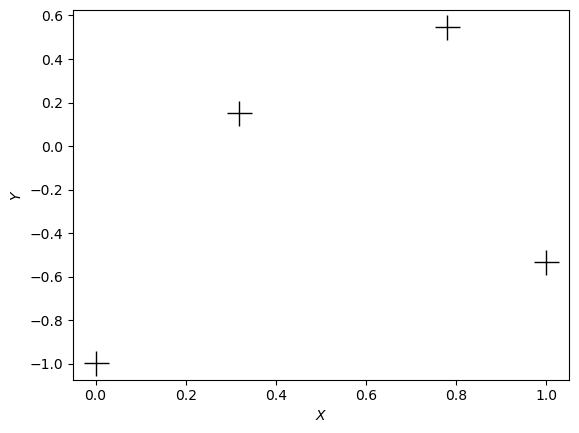

In [7]:
#Plot
plt.plot(X, y, 'k+', ms=18) #data points

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

Initial parameter guesses

In [9]:
#Lengthscale initial guess
def wavelength(X,y):
    '''
    python write a function that iteratively increases the neighborhood size on the x axis
    around the global maximum of y until it finds the smallest y value in a neighborhood
    where the y values are decreasing just before they begin increasing. return the distance
    along the x axis between the global maximum of y and that smallest y value
    '''
    ymax = np.max(y)
    ymax_i = np.argmax(y)
    ymax_x = X[ymax_i]

    loweri = 0
    upperi= len(y)-1

    ysmall_right = ymax
    ysmall_right_i = ymax_i
    i = ymax_i + 1
    while i <= upperi:    
        if y[i-1] >= y[i]: #if left y > right y
            ysmall_right = y[i]
            ysmall_right_i = i
            i = i+1
        else:
            break

    ysmall_left = ymax
    ysmall_left_i = ymax_i
    i = ymax_i - 1    
    while i >= loweri:
        if y[i] <= y[i+1]: #if left y < right y
            ysmall_left = y[i]
            ysmall_left_i = i
            i = i-1
        else:
            break
            
    if ysmall_right<ysmall_left:
        ysmall = ysmall_right
        ysmall_i = ysmall_right_i
    else:
        ysmall = ysmall_left
        ysmall_i = ysmall_left_i
    print(ysmall)
    ysmall_x = X[ysmall_i]
    print(ysmall_x)
    wavelength = np.abs(ymax_x - ysmall_x)
    print(wavelength)
    return wavelength[0]

#Initial guesses#
init_sigma_n = 0.0001 #np.std(y) # guess for observation noise
init_len_scale = wavelength(X,y)
init_sigma_f = np.abs(np.max(y) - np.min(y)) #this is the range of the observations

init_par = [init_sigma_n, init_len_scale, init_sigma_f]
init_par #these are the optimum parameters

[-0.99717612]
[0.]
[0.78037043]


[0.0001, 0.7803704285569787, 1.544624313258974]

### b) Investigating 2 hyperparameters: $l$ and $\sigma_f$
Here $\theta = \{l,\sigma_f\}$ and we want to estimate the joint posterior distriubiton $P(\theta)=p(\theta\vert X,y)$

**Previous method: Finite difference method with L-BFGS-B (variation of gradient-descent method)**

Number of iterations =  13
Min of obj funct =  3.845943174012585
sigma_n = 0.000100, l = 0.024563, sigma_f = 0.632894
Mean predictive std:  0.5712802334262858


<Figure size 640x480 with 0 Axes>

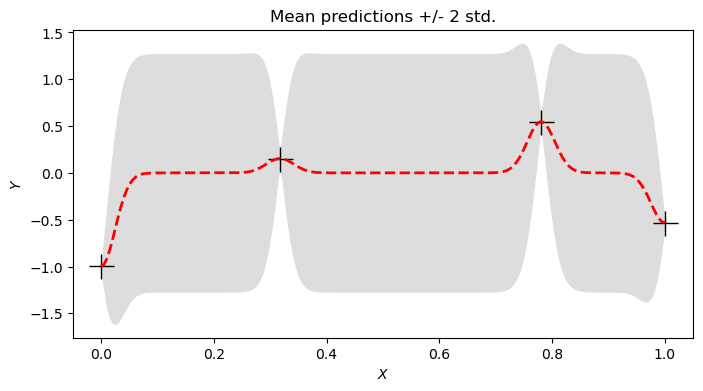

In [10]:
# Negative Marginal log-likelihood of the GP we would like to optimize (modified to allow focus on particular hyperparams)
def gp_loss_fn_focus(sigma_n, l, sigma, X, y): #input observations (X,y) and initial parameters (guess)
    N = len(X)
    
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #negative marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return mll #this is our objective function

#--------------
#Optimize l and sigma only

#Fix unwanted hyperparameters
sigma_n = init_par[0]

#Define wrapper function to optimize l
def wrapper(params, X, y, sigma_n = sigma_n):
    l, sigma = params
    return gp_loss_fn_focus(sigma_n, l, sigma, X, y)

#Initial guess for l and sigma
params0 = [init_par[1], init_par[2]]

opt_par = minimize(wrapper, params0, args=(X,y), method="L-BFGS-B", options = {'disp':True})
print("Number of iterations = ",opt_par.nit)
sigma_n, l, sigma, z = np.abs(init_par[0]), np.abs(opt_par.x[0]), np.abs(opt_par.x[1]), opt_par.fun
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

**MCMC method: Metropolis-Hastings**

In [11]:
#Marginal log-likelihood of the GP we would like to optimize (modified to allow focus on particular hyperparams)
def log_like(sigma_n, l, sigma, X, y): #input observations (X,y) and initial parameters (guess)
    N = len(X)
    
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return -1*mll

#-----------------
#Define priors
def log_prior_l(l):
    if (l <= 0):
        value = 0.00001
    else:
        value = 1
    return np.log(value)

def log_prior_sigma(sigma):
    if (sigma <= 0):
        value = 0.00001
    else:
        value = 1
    return np.log(value)

def log_prior(l,sigma): #joint prior
    #reg value = prior_l(l) * prior_sigma(sigma)
    value = log_prior_l(l) + log_prior_sigma(sigma)
    return value
    

#-----------------
#MCMC MH implementation to optimize l only
#0) Initiation
a_l = 0.00001
b_l = 10
a_sigma = 0.00001
b_sigma = 5
N = 50000

l = np.zeros(N)
sigma = np.zeros(N)
l[0] = init_par[1]
sigma[0] = init_par[2]

#Fix unwanted hyperparameters
sigma_n = init_par[0]

for i in range(1, N):
    #1) Propose new position theta[i-1] -> theta[i]' by sampling from proposal distro
    l_prop = np.random.uniform(a_l, b_l) #l[i]'
    sigma_prop = np.random.uniform(a_sigma,b_sigma)

    #2) Compute log of acceptance ratio
    prop = log_like(sigma_n, l_prop, sigma_prop, X, y) + log_prior(l_prop,sigma_prop)
    prev = log_like(sigma_n, l[i-1], sigma[i-1], X, y) + log_prior(l[i-1], sigma[i-1])
    
    log_alpha = min(prop - prev, 0)  # Acceptance ratio
    
    #3) Generate a random number u_i from [0,1]
    u = np.random.uniform(0,1) #u_i
    
    #4)
    if u <= np.exp(log_alpha):
        # Accept y as next state
        l[i] = l_prop 
        sigma[i] = sigma_prop
    else:
        # Stay at previous state of Markov chain
        l[i] = l[i-1]
        sigma[i] = sigma[i-1]

n = int(0.9*N)
C = l[-n:]
D = sigma[-n:]

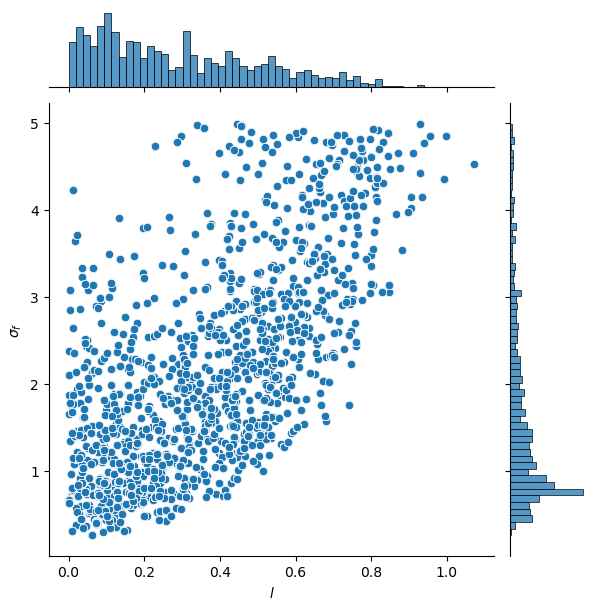

In [12]:
#Distribution of l and sigma
sns.jointplot(x=C,y=D, kind='scatter')
plt.xlabel(r'$l$')
plt.ylabel(r'$\sigma_f$')
plt.show()

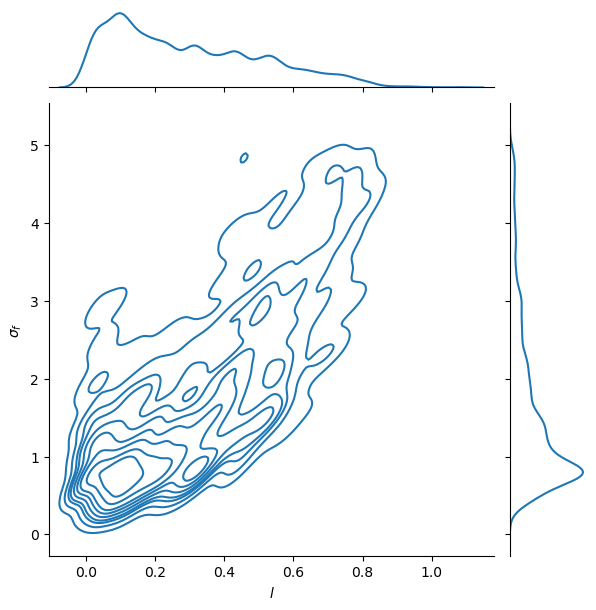

In [13]:
#Distribution of l and sigma
sns.jointplot(x=C,y=D, kind='kde')
plt.xlabel(r'$l$')
plt.ylabel(r'$\sigma_f$')
plt.show()

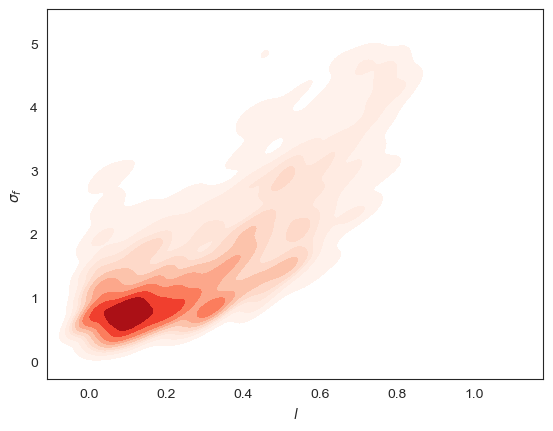

In [14]:
sns.set_style("white")
sns.kdeplot(x=C, y=D, cmap="Reds", fill=True)
plt.xlabel(r'$l$')
plt.ylabel(r'$\sigma_f$')
plt.show()

In [15]:
#Mean of l and sigma
print("Mean of l and sigma: ",np.mean(C)," ,",np.mean(D))

Mean of l and sigma:  0.29255900740035606  , 1.6332835147136548


In [16]:
print("Std of l and sigma: ",np.std(C)," ,",np.std(D))

Std of l and sigma:  0.21672515971816764  , 1.0757733556782783


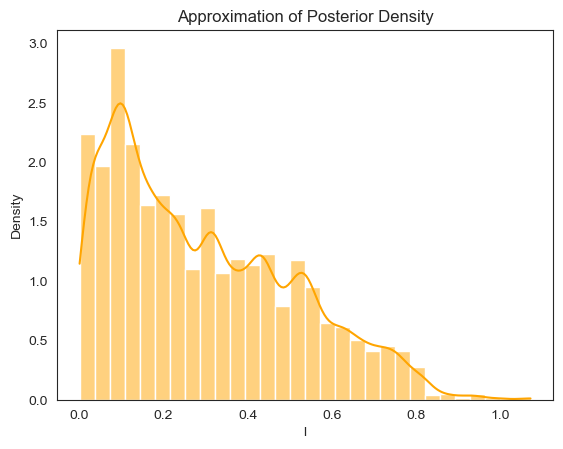

In [17]:
# Plot of MCMC approximation of the posterior
sns.histplot(C, kde=True, bins = 30, color="orange", stat="density")
plt.xlabel('l')
plt.title('Approximation of Posterior Density')
plt.show()

0.07197702151612048
0.30923487408683126


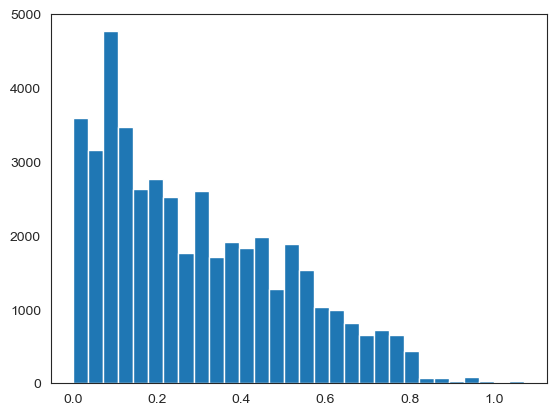

In [18]:
y_hist, x_hist, _ = plt.hist(C, bins = 30)
max_post_l = x_hist[np.where(y_hist == y_hist.max())][0]
#Maximum of posterior distribution
print(max_post_l)

#Standard devation around maximum of posterior distribution
value = np.abs(C - max_post_l)**2
max_std = np.sqrt(np.mean(value))
print(max_std)

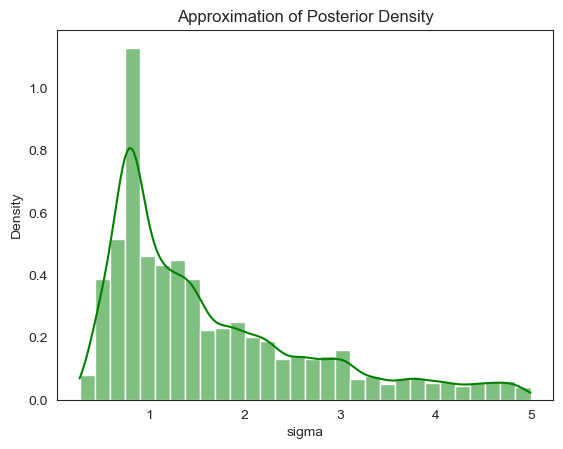

In [19]:
# Plot of MCMC approximation of the posterior
sns.histplot(D, kde=True, bins = 30, color="green", stat="density")
plt.xlabel('sigma')
plt.title('Approximation of Posterior Density')
plt.show()

0.7406741000741142
1.3978697649961696


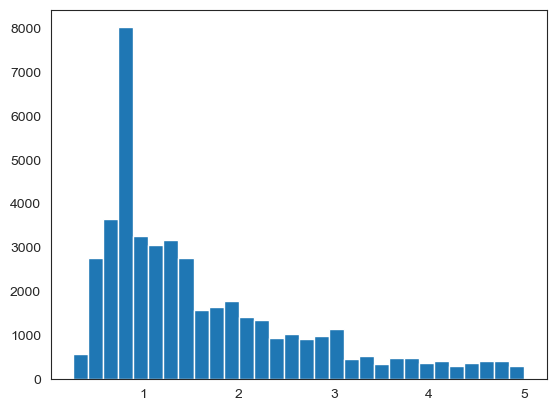

In [20]:
y_hist, x_hist, _ = plt.hist(D, bins = 30)
max_post_l = x_hist[np.where(y_hist == y_hist.max())][0]
#Maximum of posterior distribution
print(max_post_l)

#Standard devation around maximum of posterior distribution
value = np.abs(D - max_post_l)**2
max_std = np.sqrt(np.mean(value))
print(max_std)